# AI Automation for AI Fairness

When AI models contribute to high-impact decisions such as whether or
not someone gets a loan, we want them to be fair.
Unfortunately, in current practice, AI models are often optimized
primarily for accuracy, with little consideration for fairness.  This
blog post gives a hands-on example for how AI Automation can help build AI
models that are both accurate and fair.
This blog post is written for data scientists who have some familiarity
with Python. No prior knowledge of AI Automation or AI Fairness is
required, we will introduce the relevant concepts as we get to them.

Bias in data leads to bias in models. AI models are increasingly
consulted for consequential decisions about people, in domains
including credit loans, hiring and retention, penal justice, medical,
and more. Often, the model is trained from past decisions made by
humans. If the decisions used for training were discriminatory, then
your trained model will be too, unless you are careful. Being careful
about bias is something you should do as a data scientist.
Fortunately, you do not have to grapple with this issue alone.  You
can consult others about ethics. You can also ask yourself how your AI
model may affect your (or your institution's) reputation. And
ultimately, you must follow applicable laws and regulations.

_AI Fairness_ can be measured via several metrics, and you need to
select the appropriate metrics based on the circumstances.  For
illustration purposes, this blog post uses one particular fairness
metric called _disparate impact_. Disparate impact is defined as the
ratio of the rate of favorable outcome for the unprivileged group to
that of the privileged group. To make this definition more concrete,
consider the case where a favorable outcome means getting a loan, the
unprivileged group is women, and the privileged group is men.  Then if
your AI model were to let women get a loan in 30% of the cases and men
in 60% of the cases, the disparate impact would be 30% / 60% = 0.5,
indicating a gender bias towards men.  The ideal value for disparate
impact is 1, and you could define fairness for this metric as a band
around 1, e.g., from 0.8 to 1.2.

To get the best performance out of your AI model, you must experiment
with its configuration. This means searching a high-dimensional space
where some options are categorical, some are continuous, and some are
even conditional. No configuration is optimal for all domains let
alone all metrics, and searching them all by hand is impossible. In
fact, in a high-dimensional space, even exhaustively enumerating all
the valid combinations soon becomes impractical.  Fortunately, you can
use tools to automate the search, thus making you more productive at
finding good models quickly. These productivity and quality
improvements become compounded when you have to do the search over.

_AI Automation_ is a technology that assists data scientists in
building AI models by automating some of the tedious steps. One AI
automation technique is _algorithm selection_ , which automatically
chooses among alternative algorithms for a particular task. Another AI
automation technique is _hyperparameter tuning_ , which automatically
configures the arguments of AI algorithms. You can use AI automation
to optimize for a variety of metrics.  This blog post shows you how to use AI
automation to optimize for both accuracy and for fairness as measured
by disparate impact.

This blog post is generated from a [Jupyter](https://jupyter.org/)
notebook that uses the following open-source Python libraries. 
[AIF360](https://aif360.mybluemix.net/) 
is a collection of fairness metrics and bias mitigation algorithms.
The [pandas](https://pandas.pydata.org/),
[scikit-learn](https://scikit-learn.org/), and
[XGBoost](https://xgboost.ai/) libraries support
data analysis and machine learning with data structures and a
comprehensive collection of AI algorithms.
The [hyperopt](http://hyperopt.github.io/hyperopt/) library
implements both algorithm selection and hyperparameter tuning for
AI automation.
And [Lale](https://github.com/IBM/lale) is a library for
semi-automated data science; this blog post uses Lale as the backbone
for putting the other libraries together.

Our starting point is a dataset and a task. For illustration
purposes, we picked [credit-g](https://www.openml.org/d/31), also
known as the German Credit dataset. Each row describes a person
using several features that may help evaluate them as a potential
loan applicant. The task is to classify people into either
good or bad credit risks. We will use AIF360 to load the dataset.

In [1]:
import aif360.datasets
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
creditg = aif360.datasets.GermanDataset()
print(f'labels: {creditg.label_names}, '
      f'protected attributes: {creditg.protected_attribute_names}')

labels: ['credit'], protected attributes: ['sex', 'age']


AIF360 datasets carry some fairness-related metadata.
The credit-g dataset has a single label, credit, to be predicted
as the outcome.
A _protected attribute_ is a feature that partitions the
population into groups whose outcome should have parity. The
credit-g dataset has two protected attributes, sex and age.

Before we look at how to train a classifier that
is optimized for both accuracy and disparate impact, we will set a baseline,
by training a classifier that is only optimized for accuracy.
For a realistic assessment of how well the model generalizes, we
first split the data into a training set and a test set. Then,
to be able to use algorithms from the popular scikit-learn library,
we convert the data from the AIF360 representation to a Pandas
representation.

In [2]:
import pandas as pd
from lale.datasets.data_schemas import add_schema
train_ds, test_ds = creditg.split([0.7], shuffle=True, seed=42)
def to_dataframes(aif360_ds):
    X = pd.DataFrame(aif360_ds.features, columns=aif360_ds.feature_names)
    y = pd.Series(aif360_ds.labels.ravel(), name=aif360_ds.label_names[0])
    return add_schema(X), add_schema(y)
train_X, train_y = to_dataframes(train_ds)
test_X, test_y = to_dataframes(test_ds)

Next, we will import a few  algorithms from scikit-learn
and XGBoost:
a dimensionality reduction transformer (PCA) and three 
classifiers (logistic regression, gradient boosting, and a
support vector machine).

In [3]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as LR
from xgboost import XGBClassifier as XGBoost
from sklearn.svm import LinearSVC as SVM

To use AI Automation, we need to define a _search space_ ,
which is a set of possible machine learning pipelines and
their associated hyperparameters. The following code
uses Lale to define a search space.

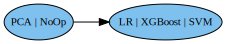

In [4]:
from lale.lib.lale import NoOp
import lale.helpers
lale.helpers.wrap_imported_operators()
planned_orig = (PCA | NoOp) >> (LR | XGBoost | SVM)
lale.helpers.to_graphviz(planned_orig)

The call to `wrap_imported_operators` augments the algorithms
that were imported from scikit-learn with metadata about
their hyperparameters. The Lale combinator `|` indicates
algorithmic choice. For example, `(PCA | NoOp)` indicates that
it is up to the AI Automation to decide whether to apply a PCA
transformer or whether to use a no-op transformer that leaves
the data unchanged. Note that the `PCA` itself is not configured
with concrete hyperparameters, since those will be left for the
AI automation to choose instead. Finally, the Lale combinator
`>>` pipes the output from the transformer into the input to the
classifier, which is itself a choice between `(LR | XGBoost | SVM)`.
The search space is encapsulated in the object `planned_orig`.

We will use hyperopt to select the algorithms and to tune their
hyperparameters. Lale provides a `HyperoptCV` that
turns a search space such as the one specified above into an
optimization problem for hyperopt. After 50 trials, we get back
the model that performed best for the default optimization
objective, which is accuracy.

100%|██████████| 50/50 [01:03<00:00,  1.27s/it, best loss: -0.7356785640047443]


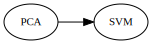

In [5]:
from lale.lib.lale.hyperopt_cv import HyperoptCV
from lale.helpers import best_estimator
import logging
lale.lib.lale.hyperopt_cv.logger.setLevel(logging.ERROR)
optimizer = HyperoptCV(estimator=planned_orig, cv=3, max_evals=50)
trained_orig = optimizer.fit(train_X, train_y)
lale.helpers.to_graphviz(best_estimator(trained_orig))

As shown by the visualization, the search found a pipeline
with a PCA transformer and an SVM classifier.
Inspecting the hyperparameters reveals which values
worked best for the 50 trials on the dataset at hand.

In [6]:
import lale.pretty_print
lale.pretty_print.ipython_display(best_estimator(trained_orig), show_imports=False)

```python
pca = PCA(whiten=True)
svm = SVM(C=11764.48346373394, dual=False, tol=0.007753646034635036)
pipeline = pca >> svm
```

We can use the accuracy score metric from scikit-learn to measure
how well the pipeline accomplishes the objective for which it
was trained.

In [7]:
from sklearn.metrics import accuracy_score
predictions = trained_orig.predict(test_X)
print(f'accuracy {accuracy_score(test_y, predictions):.1%}')

accuracy 75.3%


The accuracy is close to the state of the art for this dataset.
However, we would like our model to be not just accurate but also
fair. As discussed before, we will use disparate impact as the
fairness metric. Also, for illustrative purposes, we will only
look at one of the protected attributes, sex, which in this dataset
is encoded as 0 for female and 1 for male.

In [8]:
protected_attr = 'sex'
unpr_groups = [{protected_attr: 0.0}]
priv_groups = [{protected_attr: 1.0}]

Since we will be evaluating different models for both accuracy
and disparate impact, we define a helper function, `evaluate`
for that. The function uses the model to make predictions for
a given test dataset, then calculates the metrics based on 
those predictions.

In [9]:
import aif360.metrics
def evaluate(model, dataset):
    X, y = to_dataframes(dataset)
    predictions = model.predict(X)
    accuracy = accuracy_score(y, predictions)
    dataset_pred = dataset.copy()
    dataset_pred.labels = predictions
    fairness_metrics = aif360.metrics.BinaryLabelDatasetMetric(
        dataset_pred, unpr_groups, priv_groups)
    disparate_impact = fairness_metrics.disparate_impact()
    return {'accuracy': accuracy, 'disparate_impact': disparate_impact}

Using this helper function, we can measure both metrics on
the best model found by the original AI automation run.

In [10]:
evaluate(trained_orig, test_ds)

{'accuracy': 0.7533333333333333, 'disparate_impact': 0.7212725546058879}

The disparate impact for this model is 0.7, which is far from
the ideal value for this metric, which is 1.0. We would prefer a
model that is much more fair. The AIF360 toolkit provides several
algorithms for mitigating fairness problems. One of them is
`DisparateImpactRemover`, which modifies the features that are
not the protected attribute in such a way that it is hard to
predict the protected attribute from them. We use a Lale version
of `DisparateImpactRemover` that wraps the corresponding AIF360
algorithm for AI Automation. This algorithm has a hyperparameter
`repair_level` that we will tune with hyperparameter optimization.

In [11]:
from lale.lib.aif360 import DisparateImpactRemover
DisparateImpactRemover.hyperparam_schema('repair_level')

{'description': 'Repair amount from 0 = none to 1 = full.',
 'type': 'number',
 'minimum': 0,
 'maximum': 1,
 'default': 1}

We compose the bias mitigation algorithm in a pipeline with
a projection operator that strips out the projected
attribute, followed by a choice of classifiers as before.
In the visualization, light blue indicates trainable operators
and dark blue indicates that automation must make a choice before
the operators can be trained. Compared to the earlier pipeline,
we omit the PCA, to make it easier for the estimator to disregard
features that cause poor disparate impact.

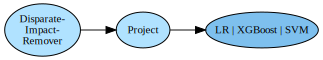

In [12]:
from lale.lib.lale import Project
dimr = DisparateImpactRemover(sensitive_attribute=protected_attr)
proj = Project(columns=[i for i, name in enumerate(creditg.feature_names)
                        if name != protected_attr])
planned_fairer = dimr >> proj >> (LR | XGBoost | SVM)
lale.helpers.to_graphviz(planned_fairer)

Unlike accuracy, which is a metric that can be computed from
predicted labels alone, fairness metrics such as disparate
impact need to look not just at labels but also at features.
For instance, disparate impact is defined by comparing outcomes
between a privileged group and an unprivileged group, so it
needs to check the protected attribute to determine group
membership for the sample person at hand. Unfortunately, the
need to look at the features from the test dataset means we
cannot use the simple Lale HyperoptClassifier that we saw
earlier. Instead, we will write more low-level code to use the
hyperopt library directly.

First, we define a loss function that incorporates both accuracy
and disparate impact. The objective will be to minimize the loss.
If the disparate impact is outside of  a margin of 10% around its
ideal of 1, the loss is 100, a high value. Otherwise, the loss is
(1 - accuracy), thus rewarding high accuracy by returning low loss.

In [13]:
def metrics_to_loss(metrics):
    if metrics['disparate_impact'] < 0.9 or 1.1 < metrics['disparate_impact']:
        return 100
    else:
        return 1.0 - metrics['accuracy']

The following code implements a search that uses the above
loss function for hyperopt, along with 3-fold cross validation
to improve generalization. The cross-validation uses two different
ways for representing the data: pandas DataFrames for training
the scikit-learn compatible pipeline and AIF360 Datasets for
measuring the disparate impact.

In [14]:
import hyperopt
import lale.search.op2hp
import statistics
import numpy as np

def search(planned, dataset, max_evals):
    test_ds = dataset.split(3, shuffle=True, seed=42)
    test_df = [to_dataframes(ds) for ds in test_ds]
    train_df = [(add_schema(pd.concat([Xy[0] for j, Xy in enumerate(test_df) if i != j])),
                 add_schema(pd.concat([Xy[1] for j, Xy in enumerate(test_df) if i != j])))
                for i in range(len(test_df))]
    def point_to_trained(search_point, train_X, train_y):
        trainable = lale.helpers.create_instance_from_hyperopt_search_space(
            planned, search_point)
        trained = trainable.fit(train_X, train_y)
        return trained
    def objective(search_point):
        losses = []
        for i in range(len(test_ds)):
            try:
                trained = point_to_trained(search_point, *train_df[i])
            except BaseException as e:
                losses.append(100)
            else:
                metrics = evaluate(trained, test_ds[i])
                losses.append(metrics_to_loss(metrics))
        loss = 100.0 if 100 in losses else statistics.mean(losses)
        return {'loss': loss, 'status': hyperopt.STATUS_OK}
    search_space = lale.search.op2hp.hyperopt_search_space(planned)
    trials = hyperopt.Trials()
    rstate = np.random.RandomState(42)
    hyperopt.fmin(objective, search_space, hyperopt.tpe.suggest,
                  max_evals, trials, rstate)
    best_point = hyperopt.space_eval(search_space, trials.argmin)
    result = point_to_trained(best_point, *to_dataframes(dataset))
    return result

Now, we have all the pieces in place to use AI Automation
on our `planned_fairer` pipeline for both accuracy and
disparate impact.

100%|██████████| 50/50 [05:46<00:00,  6.94s/it, best loss: 0.28139711186921484]
{'accuracy': 0.7466666666666667, 'disparate_impact': 0.9871794871794872}


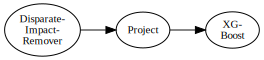

In [15]:
trained_fairer = search(planned_fairer, train_ds, max_evals=50)
print(evaluate(trained_fairer, test_ds))
lale.helpers.to_graphviz(trained_fairer)

As the result demonstrates, the best model found by AI Automation
has similar accuracy and better disparate impact as the one we saw
before. Also, it has tuned the repair level and
has picked and tuned a classifier.

In [16]:
lale.pretty_print.ipython_display(trained_fairer, show_imports=False)

```python
disparate_impact_remover = DisparateImpactRemover(repair_level=0.19581636555085896, sensitive_attribute='sex')
project = Project(columns=[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57])
xgboost = XGBoost(booster='dart', colsample_bylevel=0.2805507229288652, colsample_bytree=0.4604821842516554, learning_rate=0.03795178827802115, max_depth=6, min_child_weight=16, n_estimators=1379, reg_alpha=0.38557467442503696, reg_lambda=0.6896956443393265, subsample=0.6443224212773278)
pipeline = disparate_impact_remover >> project >> xgboost
```

These results may vary by dataset and search space.

In summary, this blog post showed you how to use AI Automation
from Lale, while incorporating a fairness mitigation technique
into the pipeline and a fairness metric into the objective.
Of course, this blog post only scratches the surface of what can
be done with AI Automation and AI Fairness. We encourage you to
check out the open-source projects Lale and AIF360 and use them
to build your own fair and accurate models!

- Lale: https://github.com/IBM/lale
- AIF360: https://aif360.mybluemix.net/